In [6]:
import fitz  # PyMuPDF
import openpyxl
from features.gemini.agent import Agent
import json
import pathlib as Path
from utils.constants import ROOTLIB
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical
from numpy import array
from numpy import argmax
import matplotlib.pyplot as plt

from keras._tf_keras.keras import Sequential
from keras._tf_keras.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Conv1D, Dropout, GlobalAveragePooling2D
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import EarlyStopping
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from matplotlib import cm

d:\source\Mockup-AI-Sweden\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
def read_stat_proj(filename):
    df= pd.read_excel(filename,header=0)
    return df

def norm_image(pivot_df):
    pivot_df_filled = pivot_df.fillna(0)
    if 'Report Date' in pivot_df_filled.columns:
        pivot_df_filled = pivot_df_filled.drop(columns='Report Date')
    
    image_vectors = pivot_df_filled.to_numpy()
    return image_vectors

def join_data(df1, df2):
    array1=np.array(df1)
    array2=np.array(df2)
    combined = np.hstack((array1, array2))
    return combined 

def calc_ratio(df):
    df_filtered = df[df["Category"] != "Total Project Est:"].copy()
    df_filtered["Ratio"] = df_filtered["Man-Hours (Actual)"] / df_filtered["Man-Hours (Est)"]
    result_df = df_filtered.pivot(index="Report Date", columns="Category", values="Ratio").reset_index()
    result_df.columns.name = None  # Remove the columns index name
    result_df = result_df.sort_index(axis=1)
    return result_df

def calc_per_date(df):
    df_filtered = df[df["Category"] != "Total Project Est:"].copy()
    total_per_date = df_filtered.groupby("Report Date")["Man-Hours (Actual)"].transform("sum")
    df_filtered["Actual_vs_DailyTotal"] = df_filtered["Man-Hours (Actual)"] / total_per_date
    pivot_df = df_filtered.pivot(index="Report Date", columns="Category", values="Actual_vs_DailyTotal")
    pivot_df = pivot_df.sort_index(axis=1)
    return pivot_df

def filter(df,proj_id):
    df2=pd.DataFrame()
    cat_list2=pd.unique(df[df["Project"]==proj_id]["Category"])
    date_list3=pd.unique(df[df["Project"]==proj_id]["Report Date"])
    for category in cat_list2:
        for date in date_list3: 
            df_temp=df[(df["Project"] == proj_id) & 
                     (df["Category"] == category) & 
                     (df["Report Date"] == date)][["Category","Report Date","Man-Hours (Est)","Man-Hours (Actual)"]]
            if not df_temp.empty:
                df2 = pd.concat([df2, df_temp], ignore_index=True)
    return df2, date_list3

def toOneHot(data):
    code=[]
    for x in data:
        if x=='normal':
            code.append(0)
        else:
            code.append(1)
    return np.array(code)



In [2]:
def arrayimage(img):
    gray=np.array(img)
    rgb = np.stack([gray]*3, axis=-1)
    return np.array(rgb/255)


def new_fix_the_true(filename, type_data):
    df=read_stat_proj(filename)
    proj_list=df["Project"].unique()
    zeros_array = np.zeros(10)
    outall = []
    truth = []
    # arrays with color...
    #colormap = cm.get_cmap('viridis')
    output=[]

    variation = 0.10

    for x in proj_list:
        datumen=df[df["Project"]==x]['Report Date'].dropna().unique()
        data_df, datum = filter(df,x)
        per_date=calc_per_date(data_df)
        per_ratio=calc_ratio(data_df)
        joined_df=join_data(norm_image(per_date), norm_image(per_ratio))
        i = len(datumen) 
        for t in range(i-2):
            img=[]
            for z in range(0+t,3+t,1):
                img.append(joined_df[z]*255)
            if len(img)>0:
                output.append(arrayimage(img))
                arr=arrayimage(img)
                for teta in range(70):
                    noise = (np.random.rand(*arr.shape) * 2 - 1) * variation * arr  
                    noisy_arr = arr + noise
                    # Clip values to stay in the 0-1 range
                    noisy_arr = np.clip(noisy_arr, 0.0, 1.0)
                    output.append(noisy_arr)
                    truth.append(type_data)
                truth.append(type_data)

    return output, truth



def fix_the_true(filename, type_data):
    df=read_stat_proj(filename)
    proj_list=df["Project"].unique()
    zeros_array = np.zeros(10)
    outall = []
    truth = []
    #colormap = cm.get_cmap('viridis')
    output=[]
    for x in proj_list:
        datumen=df[df["Project"]==x]['Report Date'].dropna().unique()
        data_df, datum = filter(df,x)
        per_date=calc_per_date(data_df)
        per_ratio=calc_ratio(data_df)
        joined_df=join_data(norm_image(per_date), norm_image(per_ratio))
        i = len(datumen)  
        if i < 4:
            row = list(range(4))
            for z in row:
                img=[]
                for w in range(z):
                    img.append(joined_df[w])
                if len(img)>0:
                    for z in range(4-z):
                        img.append(zeros_array)
                    output.append(arrayimage(img))
                    truth.append(type_data)
        if i > 3:
            row = list(range(4))
            for z in row:
                img=[]
                for w in range(z):
                    img.append(joined_df[w])
                if len(img)>0:
                    for z in range(4-z):
                        img.append(zeros_array)
                    output.append(arrayimage(img).astype(np.uint8))
                    truth.append(type_data)
            img=[]
            for t in range(i-3):
                for z in range(0+t,4,1):
                    img.append(joined_df[z])
                if len(img)>0:
                    output.append(arrayimage(img).astype(np.uint8))
                    truth.append(type_data)
    return np.array(output),truth

In [ ]:
def CNN_model(input_shape=(3, 10, 3),learning_rate=0.001, drop_rate=0.3, kernels=[32, 64]):

    print(drop_rate)
    # default learning rate in Adam, Adam is an optimizor for learning rate
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    # creating a convulutional layer 
    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel, 
            kernel_size=(3, 3), 
            activation="relu", 
            kernel_initializer="he_normal", 
            padding='same',
            input_shape=input_shape, 
        )

        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2,  padding='same')) 

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(2, activation="softmax")) # sotfmax -> probabilities for each output

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )

    return model




def build_model(input_shape=(4, 10, 3), num_classes=2, learning_rate=0.001):
    model = Sequential(name="Small_CNN")
    # Conv Layer 1
    model.add(Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=input_shape
    ))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Conv Layer 2
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # For classification

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

[0 0 0 ... 1 1 1]
0.5
Epoch 1/50


d:\source\Mockup-AI-Sweden\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\source\Mockup-AI-Sweden\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 76/116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5411 - loss: 0.7673

d:\source\Mockup-AI-Sweden\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5391 - loss: 0.7641 - val_accuracy: 0.5000 - val_loss: 0.6253
Epoch 2/50
  6/116 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6955 - loss: 0.6229

d:\source\Mockup-AI-Sweden\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6337 - loss: 0.6487 - val_accuracy: 0.8291 - val_loss: 0.5084
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7243 - loss: 0.5487 - val_accuracy: 0.8980 - val_loss: 0.4262
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8073 - loss: 0.4670 - val_accuracy: 0.9235 - val_loss: 0.3432
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8608 - loss: 0.3905 - val_accuracy: 0.9490 - val_loss: 0.2756
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8984 - loss: 0.3434 - val_accuracy: 1.0000 - val_loss: 0.2078
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8948 - loss: 0.3008 - val_accuracy: 1.0000 - val_loss: 0.1568
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9399 - loss: 0.2316 - val_accuracy: 1.0000 - val_loss: 0.1281
Epoch 9/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9454 - loss: 0.1855 - val_accuracy: 1.0000 - val_

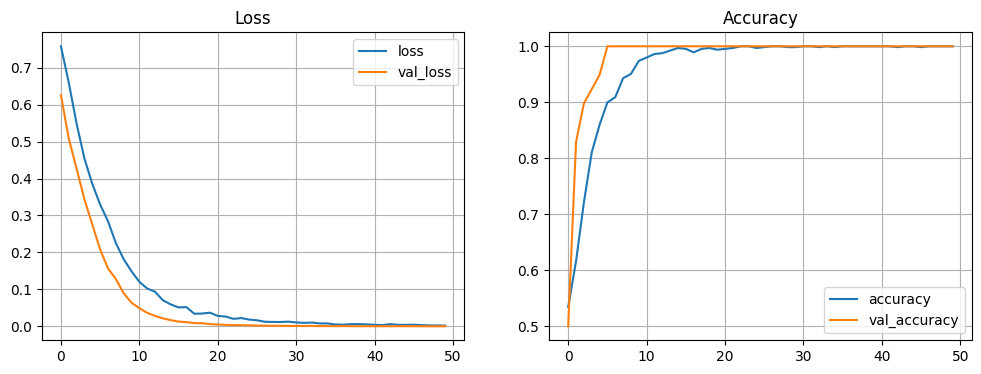

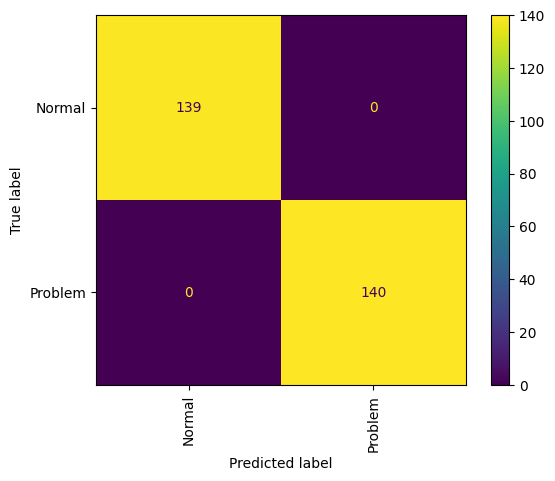

In [ ]:
def run_model():

    datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=False,
        fill_mode='nearest'
    )

    X_s,y_s =new_fix_the_true('../database/project_test_budget_hours.xlsx','normal')
    X_f,y_f =new_fix_the_true('../database/project_fake_budget_hours.xlsx','fake')
    

    # Use the generator
    batch_size = 8
    y_train=toOneHot(y_s)
    y_fake=toOneHot(y_f)
    # print("X_s shape:", X_s.shape)
    # print("y_s shape:", y_train.shape)
    X_tot= np.concatenate((X_s, X_f), axis=0)
    y_tot= np.concatenate((y_train, y_fake), axis=0)

    print(y_tot)

    X_train, X_val, ytrain, y_val = train_test_split(X_tot, y_tot, test_size=0.3, random_state=42, stratify=y_tot)

    X_train_real, X_test, ytrain_real, y_test = train_test_split(X_train, ytrain, test_size=0.3, random_state=42)
    train_generator = datagen.flow(X_train_real, ytrain_real, batch_size=batch_size)

    # model = build_model(input_shape=(3, 10, 3), num_classes=2, learning_rate=0.0001)
    model=CNN_model(input_shape=(3, 10, 3),learning_rate=.0001, drop_rate=.5, kernels= [32, 64])
    steps_per_epochs = len(X_train)/batch_size
    validation_steps = len(X_val)/batch_size


    early_stopper = EarlyStopping(
        monitor="val_acc", mode="max", patience=150, restore_best_weights=True
    )


    test_image_generator = ImageDataGenerator()
    val_generator = test_image_generator.flow(X_val, np.array(y_val), batch_size=batch_size)

    model.fit(
        train_generator,
        steps_per_epoch=int(steps_per_epochs),
        epochs=50,
        callbacks=[early_stopper],
        validation_data=val_generator,
        validation_steps=int(validation_steps),
        verbose=1,
    )
    metrics = pd.DataFrame(model.history.history)
    print(metrics.head())

    def plot_metrics(metrics):
        _, ax = plt.subplots(1,2, figsize = (12,4))
        metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
        metrics[["accuracy", "val_accuracy"]].plot(ax = ax[1], title = "Accuracy", grid = True)
        
    plot_metrics(metrics)

    from sklearn.metrics import (
        classification_report,
        confusion_matrix,
        ConfusionMatrixDisplay,
    )

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred, axis = 1)

    labels=["Normal", "Problem"]

    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    plt.xticks(rotation = 90)

    model.save("d:/source/Mockup-AI-Sweden/database/model.keras")
    
run_model()

In [ ]:
m3=CNN_model(input_shape=(3, 10, 3),learning_rate=.0001, drop_rate=.5, kernels= [32, 64])
m3.summary()

0.5


d:\source\Mockup-AI-Sweden\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred)

y_pred = np.argmax(y_pred, axis = 1)

labels=["Normal", "Fall"]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
plt.xticks(rotation = 90)


In [7]:
Xs, ys = new_fix_the_true('../database/Budget-demo.xlsx',"normal") 

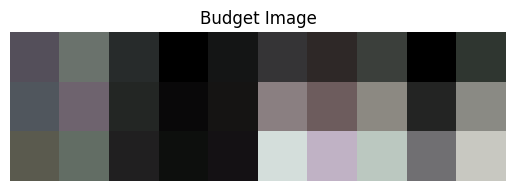

In [9]:
image_array = Xs[1]

# Show as image
plt.imshow(image_array, cmap='gray') 
plt.axis('off')  # turn off axes
plt.title("Budget Image")
plt.show()
